# Demo for how to track a single RBC from its kymogram and estimate the RBC's speed

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sl2pm import track_rbc
from sl2pm.models import rbc
from sl2pm.misc import fitted_params

Load a kymogram, consisting of three consecutive line-scans

In [2]:
kymogram = np.load('rbc_linescans.npy')

Enter PMT parameters (known from the calibration)

In [3]:
ALPHA = 0.452
SIGMA = 6.0
GAIN = 3/ALPHA

## Tracking a single RBC, visualising and inspecting the fits

Fit three consecutive line-scans.
After each fit, we show raw line-scan (black staircase curve) and its fit (blue curve), respectively. 

Fitting line-scan 1/3...
Optimization terminated successfully.
Fitting line-scan 2/3...
Optimization terminated successfully.
Fitting line-scan 3/3...
Optimization terminated successfully.


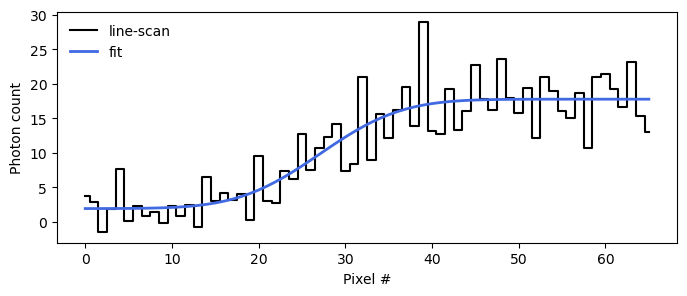

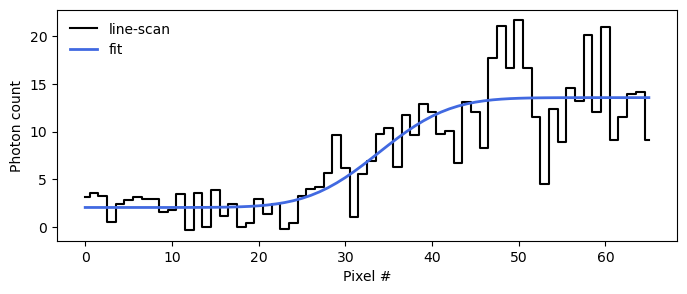

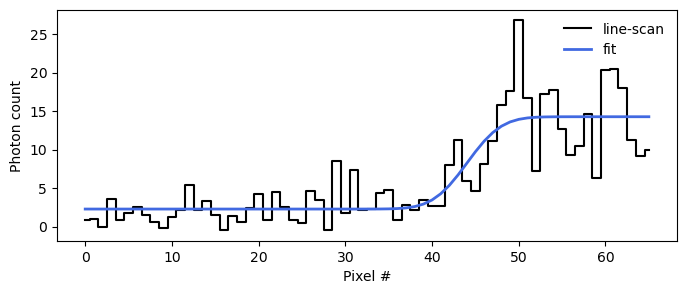

In [4]:
x = np.arange(len(kymogram[0]))

rbc_loc = [] # Fitted RBC locations and their error bars

for i, linescan in enumerate(kymogram, start=1):
    
    print(f'Fitting line-scan {i}/{len(kymogram)}...')
    
    optim_res = track_rbc.mle_fit(linescan, 
                                 ALPHA, 
                                 SIGMA, 
                                 mu=0, 
                                 sigma_blur=1, 
                                 delta_s=4, 
                                 s_max=700, 
                                 minimize_options=dict(gtol=1e-3)
                                )
    
    print(optim_res.message)
    
    pars = fitted_params(optim_res, ['b', 'A', 's', 'xo'])
    rbc_loc.append(pars['xo'])

    ### Plot line-scans and their fits
    fig, ax = plt.subplots(figsize=(8, 3))
    
    ax.step(x, linescan/GAIN, c='k', where='mid', label='line-scan')
    ax.plot(x, rbc(x, *[val for val, err in pars.values()]), c='royalblue', label='fit', lw=2)
    ax.legend(frameon=False)
    ax.set_xlabel('Pixel #')
    ax.set_ylabel('Photon count')
    
rbc_loc = np.array(rbc_loc)

## Estimating the RBC's speed

Estimate RBC speed [mm/sec] from the three estimated RBC locations

In [5]:
dt = 0.00166 # [sec] inverse sampling rate of line-scans
t = np.arange(3)*dt

pixel_width = 1e-4 # [mm]

result = track_rbc.rbc_speed(t, rbc_loc[:,0], rbc_loc[:,1])

print(f'RBC speed = {result["speed"]*pixel_width:.3f}+/-{result["speed_err"]*pixel_width:.3f} mm/sec')

RBC speed = 0.520+/-0.051 mm/sec
